In [942]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler

### Part 1: Cleveland Heart Attack Dataset

In [943]:
def load_cleveland_data(file_path):
    data = pd.read_csv(file_path)
    data['disease'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('disease', axis=1)
    y = data['disease']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled_df.values, y.values, X.columns


In [944]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, feature_mask=None):
        self.k = k
        self.feature_mask = feature_mask

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_[i] for i in k_indices]
        return np.argmax(np.bincount(k_nearest_labels))

In [945]:
def cross_validate(X, y, k, feature_mask, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_scores = []
    precisions = []
    recalls = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = kNN(k=k, feature_mask=feature_mask)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        
        # print(f"Fold - Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")
    
    return f1_scores, precisions, recalls

In [946]:
def feature_importance(X, y, feature_names):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X, y)
    importances = dt.feature_importances_
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return feature_importance

In [948]:
def plot_feature_separability(ax, X, y, feature_name, feature_names):
    # Get the index of the feature
    feature_index = list(feature_names).index(feature_name)
    
    # Separate the feature values for each class
    feature_values_0 = X[y == 0, feature_index]
    feature_values_1 = X[y == 1, feature_index]
    
    # Plot histograms
    sns.histplot(feature_values_0, kde=True, color='blue', alpha=0.5, label='No Heart Disease', ax=ax)
    sns.histplot(feature_values_1, kde=True, color='red', alpha=0.5, label='Heart Disease', ax=ax)
    
    ax.set_title(f'Distribution of {feature_name}')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Density')
    ax.legend()

def plot_multiple_features(X, y, feature_names, selected_features, save_dir='plots', filename='feature_distributions.png'):
    # Calculate grid dimensions
    n_features = len(selected_features)
    n_cols = min(3, n_features)  # Max 3 columns
    n_rows = math.ceil(n_features / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle('Feature Distributions for Each Class', fontsize=16)
    
    # Flatten axes
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for i, feature in enumerate(selected_features):
        plot_feature_separability(axes[i], X, y, feature, feature_names)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the plot
    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [949]:
def elbow(X, y, k_range, feature_mask, save_dir='plots', filename='elbow_plot.png'):
    # Apply the feature mask
    X_masked = X[:, feature_mask]

    X_train, X_test, y_train, y_test = train_test_split(X_masked, y, test_size=0.2, random_state=42)

    scores = []
    for k in k_range:
        knn = kNN(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        scores.append((precision, recall, f1))

    precisions, recalls, f1_scores = zip(*scores)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, f1_scores)
    plt.xlabel('k')
    plt.ylabel('F1 Score')
    plt.title('Elbow Plot: F1 Score vs k')
    plt.grid(True)

    plt.tight_layout()
    
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the plot
    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path)
    plt.show()
    plt.close()
    

In [950]:
# Load the data
X, y, feature_names = load_cleveland_data('data/cleveland.csv')

importance_results = feature_importance(X, y, feature_names)
print("Feature Importance:")
print(importance_results)

Feature Importance:
thal        0.279725
cp          0.151193
ca          0.108062
thalach     0.083773
chol        0.079608
oldpeak     0.076073
age         0.072169
trestbps    0.050094
slope       0.031960
sex         0.028341
restecg     0.016259
exang       0.012420
fbs         0.010323
dtype: float64


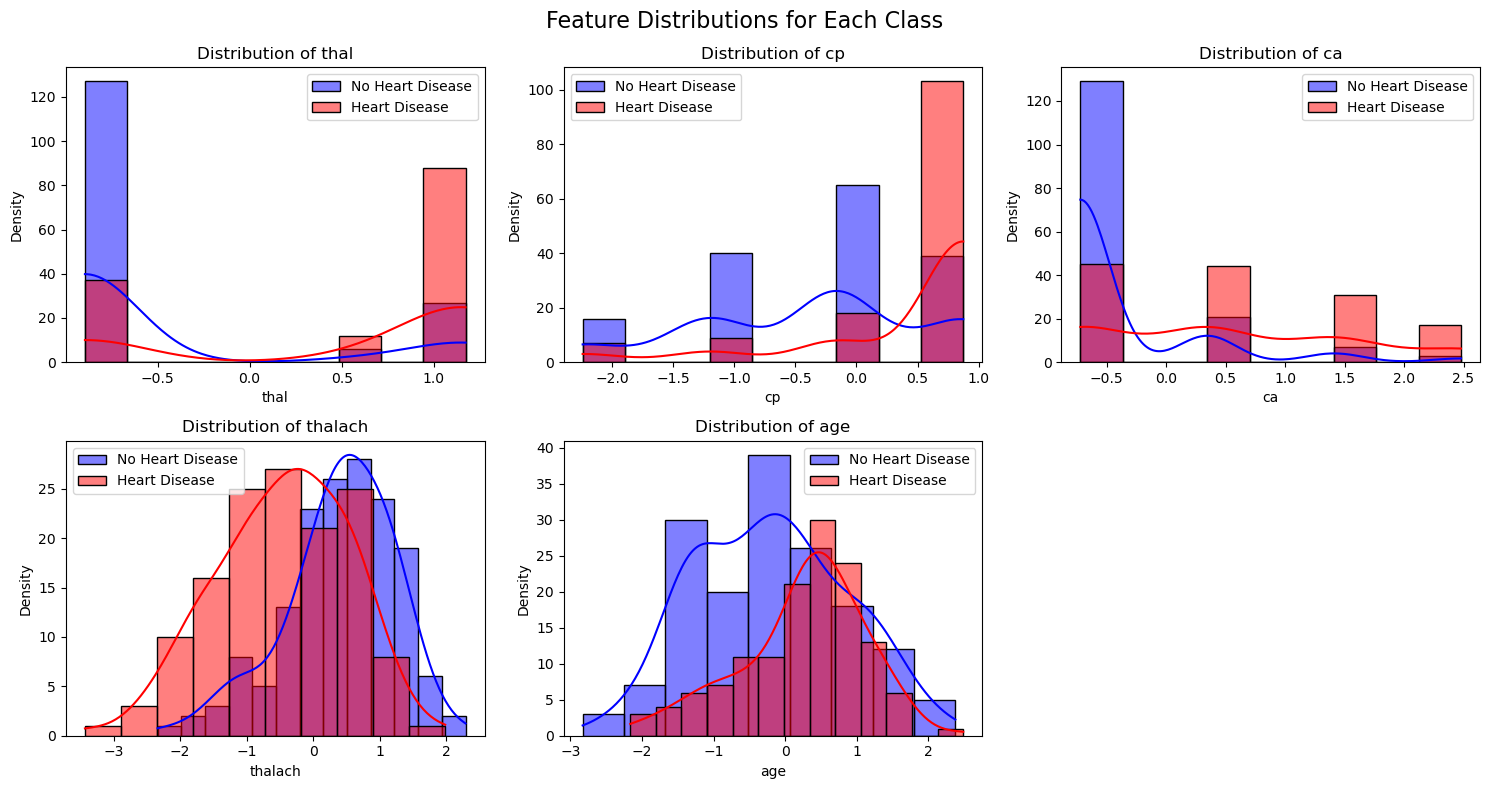

In [951]:
selected_features = ['thal', 'cp', 'ca', 'thalach', 'age']

# Examine the separability of the selected features
plot_multiple_features(X, y, feature_names, selected_features, 'plots/part1')

# Create feature mask
feature_mask = np.isin(feature_names, selected_features)

/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

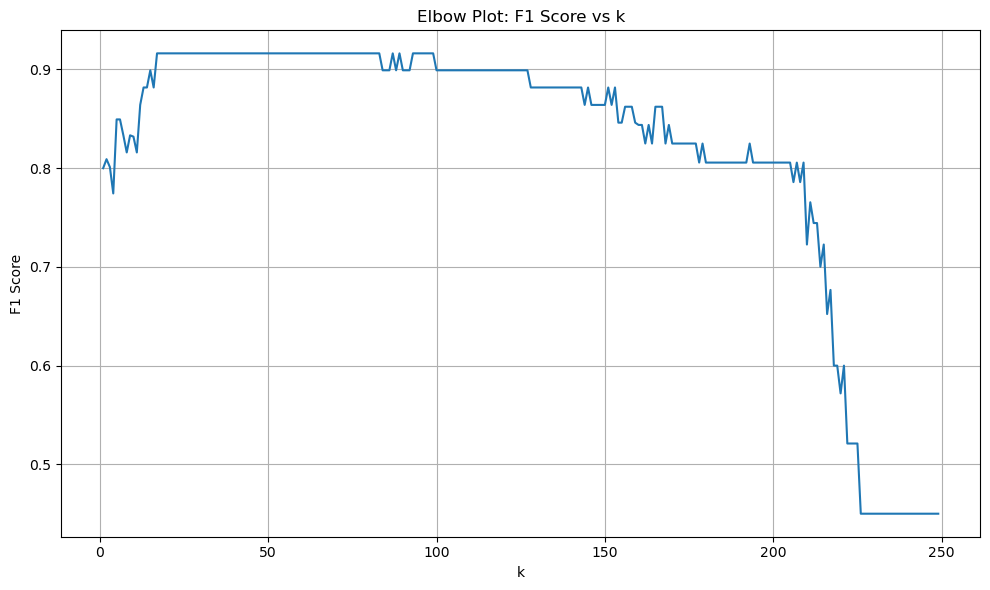

In [952]:
elbow(X, y, range(1, 250), feature_mask, 'plots/part1', 'elbow_plot.png')

In [953]:
# Set k based on our elbow plot
k = 150

# Perform cross-validation
f1_scores, precisions, recalls = cross_validate(X, y, k, feature_mask)

# Print results
print(f"Selected features: {selected_features}")
print(f"k value: {k}")
print("\nCross-validation results:")
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1 Score: {f1_scores[i]:.3f}")

print("\nMean scores:")
print(f"Precision: {np.mean(precisions):.3f} (+/- {np.std(precisions):.3f})")
print(f"Recall: {np.mean(recalls):.3f} (+/- {np.std(recalls):.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

# Train a model for the test set
final_model = kNN(k=k, feature_mask=feature_mask)
final_model.fit(X, y)

Selected features: ['thal', 'cp', 'ca', 'thalach', 'age']
k value: 150

Cross-validation results:
Fold 1:
  Precision: 0.818
  Recall: 0.818
  F1 Score: 0.818
Fold 2:
  Precision: 1.000
  Recall: 0.769
  F1 Score: 0.870
Fold 3:
  Precision: 0.917
  Recall: 0.647
  F1 Score: 0.759
Fold 4:
  Precision: 0.846
  Recall: 0.611
  F1 Score: 0.710
Fold 5:
  Precision: 0.929
  Recall: 0.650
  F1 Score: 0.765
Fold 6:
  Precision: 0.889
  Recall: 0.615
  F1 Score: 0.727
Fold 7:
  Precision: 0.778
  Recall: 0.583
  F1 Score: 0.667
Fold 8:
  Precision: 1.000
  Recall: 0.692
  F1 Score: 0.818
Fold 9:
  Precision: 0.818
  Recall: 0.818
  F1 Score: 0.818
Fold 10:
  Precision: 0.583
  Recall: 0.778
  F1 Score: 0.667

Mean scores:
Precision: 0.858 (+/- 0.116)
Recall: 0.698 (+/- 0.085)
F1 Score: 0.762 (+/- 0.066)


kNN(feature_mask=array([ True, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True]),
    k=150)

In [954]:
# Function to predict on challenge dataset
def predict_challenge(challenge_file, model):
    X_challenge, y_challenge, _ = load_data(challenge_file)
    y_pred = model.predict(X_challenge)
    return f1_score(y_challenge, y_pred)

# Predict on the sample test dataset
challenge_f1 = predict_challenge('data/cleveland-test-sample.csv', final_model)
print(f"\nF1 Score on challenge dataset: {challenge_f1:.3f}")


F1 Score on challenge dataset: 0.848


### Part 2: CDC BRFSS 2015 Diabetes Dataset

In [955]:
def load_diabetes_data(file_path):
    data = pd.read_csv(file_path)
    # data['Diabetes_binary'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    # data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('Diabetes_binary', axis=1)
    y = data['Diabetes_binary']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled_df.values, y.values, X.columns

In [956]:
X, y, feature_names = load_diabetes_data('data/diabetes_sample.csv')
importance_results = feature_importance(X, y, feature_names)
print("Feature Importance:")
print(importance_results)

Feature Importance:
BMI                     0.187131
GenHlth                 0.130863
Age                     0.126637
Income                  0.110922
MentHlth                0.078607
Education               0.067365
PhysHlth                0.063850
HighChol                0.049450
DiffWalk                0.036655
PhysActivity            0.022021
HighBP                  0.021847
HeartDiseaseorAttack    0.021308
Sex                     0.016108
Fruits                  0.015553
AnyHealthcare           0.011427
NoDocbcCost             0.010739
Smoker                  0.008224
Veggies                 0.007797
Stroke                  0.007382
HvyAlcoholConsump       0.006111
CholCheck               0.000000
dtype: float64


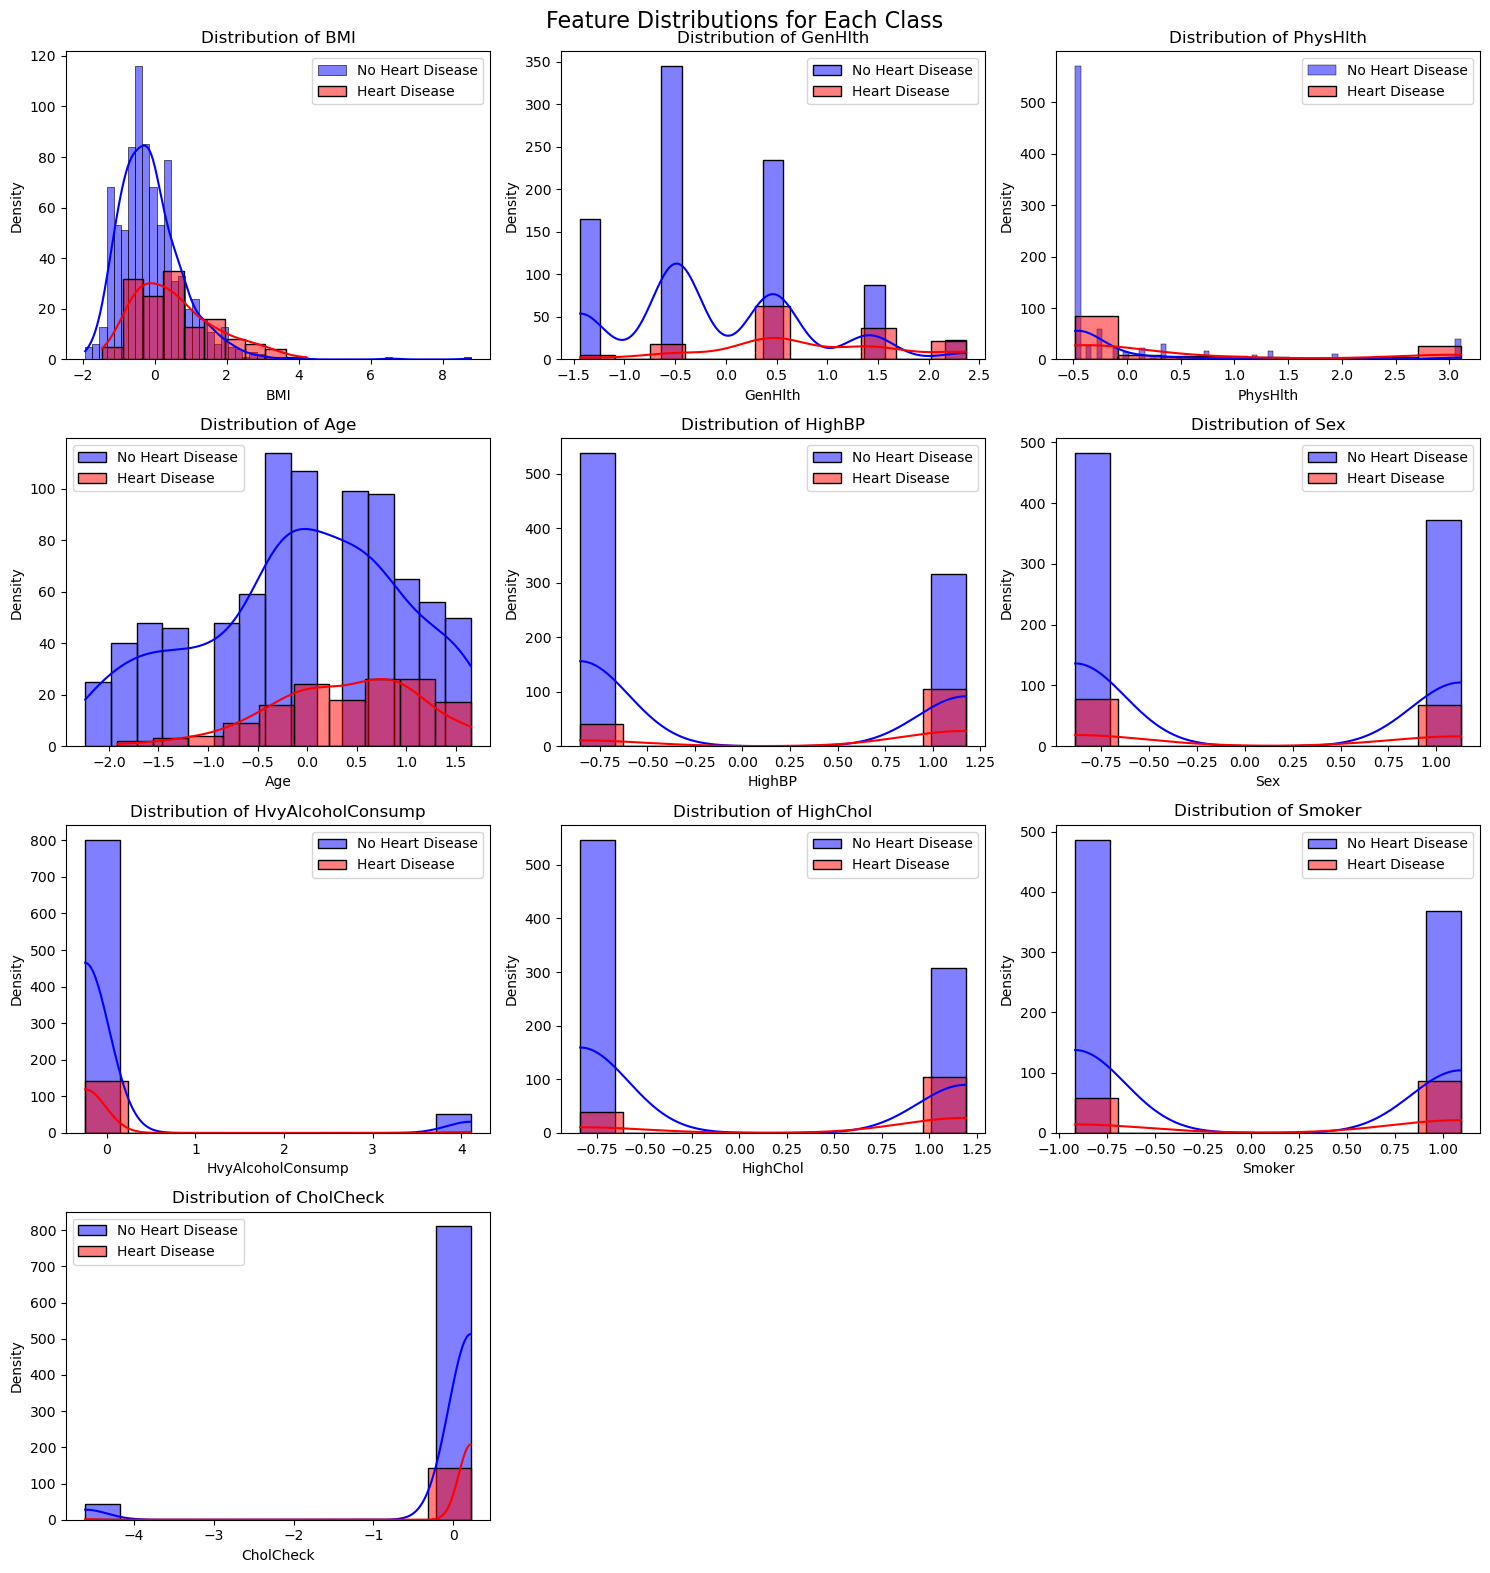

In [957]:
selected_features = ['BMI', 'GenHlth', 'PhysHlth', 'Age', 'HighBP', 'Sex', 'HvyAlcoholConsump', 'HighChol', 'Smoker', 'CholCheck']

plot_multiple_features(X, y, feature_names, selected_features, 'plots/part2')

# Create feature mask
feature_mask = np.isin(feature_names, selected_features)

/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

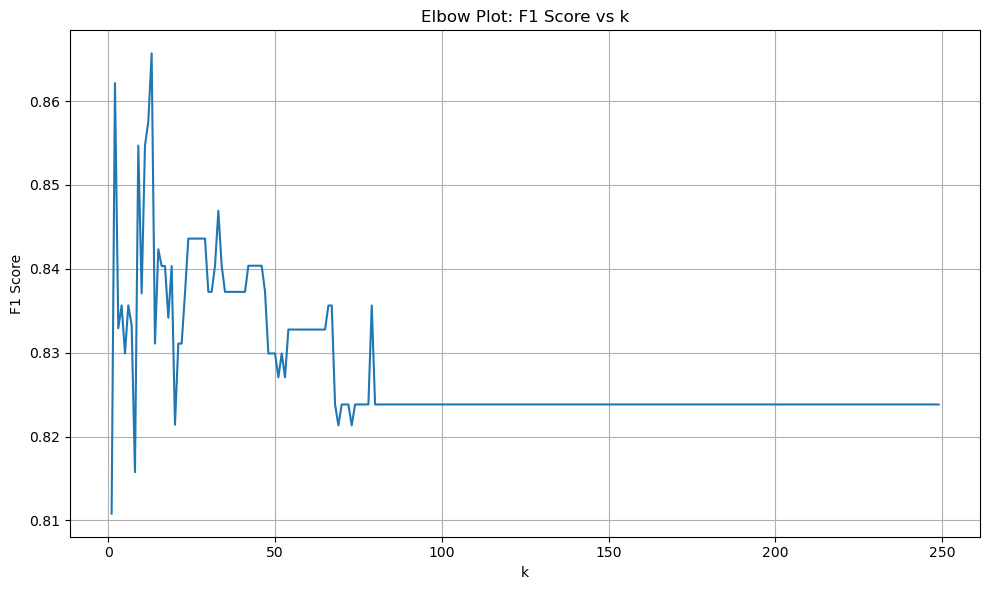

In [958]:
elbow(X, y, range(1, 250), feature_mask, 'plots/part2', 'elbow_plot.png')

In [959]:
# Set k based on our elbow plot
k = 5

# Perform cross-validation
f1_scores, precisions, recalls = cross_validate(X, y, k, feature_mask)

# Print results
print(f"Selected features: {selected_features}")
print(f"k value: {k}")
print("\nCross-validation results:")
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1 Score: {f1_scores[i]:.3f}")

print("\nMean scores:")
print(f"Precision: {np.mean(precisions):.3f} (+/- {np.std(precisions):.3f})")
print(f"Recall: {np.mean(recalls):.3f} (+/- {np.std(recalls):.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

# Train a model for the test set
final_model = kNN(k=k, feature_mask=feature_mask)
final_model.fit(X, y)

Selected features: ['BMI', 'GenHlth', 'PhysHlth', 'Age', 'HighBP', 'Sex', 'HvyAlcoholConsump', 'HighChol', 'Smoker', 'CholCheck']
k value: 5

Cross-validation results:
Fold 1:
  Precision: 0.111
  Recall: 0.111
  F1 Score: 0.111
Fold 2:
  Precision: 0.333
  Recall: 0.200
  F1 Score: 0.250
Fold 3:
  Precision: 0.375
  Recall: 0.167
  F1 Score: 0.231
Fold 4:
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000
Fold 5:
  Precision: 0.375
  Recall: 0.300
  F1 Score: 0.333
Fold 6:
  Precision: 0.429
  Recall: 0.300
  F1 Score: 0.353
Fold 7:
  Precision: 0.667
  Recall: 0.118
  F1 Score: 0.200
Fold 8:
  Precision: 0.571
  Recall: 0.222
  F1 Score: 0.320
Fold 9:
  Precision: 0.200
  Recall: 0.056
  F1 Score: 0.087
Fold 10:
  Precision: 0.250
  Recall: 0.167
  F1 Score: 0.200

Mean scores:
Precision: 0.331 (+/- 0.191)
Recall: 0.164 (+/- 0.092)
F1 Score: 0.209 (+/- 0.109)


kNN(feature_mask=array([ True,  True,  True,  True,  True, False, False, False, False,
       False,  True, False, False,  True, False,  True, False,  True,
        True, False, False]),
    k=5)